In [37]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

import numpy as np
import matplotlib.pyplot as plt
import logging
import os
import time
import pandas as pd

dimensions = 2
batch_size = 10
iterations = 30
bounds = bounds = {'x[1]':(-5,10),'x[2]':(0,15)}
max_kappa = 0.1
min_kappa = 0.01
random_seed = 10
csv_path = '/work4/clf/david/Bayesian/BayesianGit/BayesianOptimiser2/Benchmarking/BraninHoo/PBOResults.csv'
log_path = '/work4/clf/david/Bayesian/BayesianGit/BayesianOptimiser2/Benchmarking/BraninHoo/PBOlog.log'

if os.path.exists(csv_path):
    os.remove(csv_path)

In [38]:
def BraninHoo(x):
    
    # Calculate the function value
    y = (x[0]- (5.1 / (4 * np.pi ** 2)) * x[1] ** 2 + (5 / np.pi) * x[0] - 6) ** 2
    y += 10 * (1 - (1 / (8 * np.pi))) * np.cos(x[0]) + 10

    # Add the constraint
    constraint = (x[0] - 2.5) ** 2 + (x[1] - 7.5) ** 2 - 50 >= 0
    if constraint is True:
        y = 200  # Apply penalty for constraint violation
        
    # Make function negative to find the minimum
    y = -y

    return y

In [39]:
def WriteOutput(csv_file, raw_X, raw_Y, iteration):
    """
    Optional function to write results from each simulation to csv file.

    Parameters:
    csv_file (string): path to the csv file
    raw_X (2d array): the whole batch of input parameters
    raw_Y (2d array): the batch of output values
    """

    iteration_numbers = np.full(len(raw_X), iteration)
    simulation_numbers = range(0, len(raw_X))

    data = {
        'Iteration': np.array(iteration_numbers),
        'Simulation': np.array(simulation_numbers),
        'Result': raw_Y[:],
    }

    # Add raw_X values with column names
    for i in range(np.shape(raw_X)[1]):
        data[f'X{i}'] = raw_X[:, i]

    df = pd.DataFrame(data)

    # Check the output file exists, if not create it and write the headers of each column. Otherwise, append the new row to the file
    if not os.path.isfile(csv_file):
        df.to_csv(csv_file, index=False)
    else:
        df.to_csv(csv_file, mode='a', header=False, index=False)


    return

In [41]:
# Check if the log file exists and delete it if it does
if os.path.exists(log_path):
    os.remove(log_path)

# Setup logger and set level to INFO
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Setup Log_handler - set mode to 'w' to write
log_handler = logging.FileHandler(log_path, mode='w')
log_handler.setLevel(logging.INFO)

# Define the log format (preamble before your message is displayed)
log_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_handler.setFormatter(log_format)

# add the handler to the logger object so you can start writing to the log file
logger.addHandler(log_handler)

In [43]:
Optimiser = BayesianOptimization(f=None, pbounds=bounds, verbose=2, random_state=1)

random_counter = 0

for j in range(iterations): 

    Optimiser.set_bounds(bounds)
   
    start_time = time.time()
    raw_X = []
    logger.info(f'Getting next batch of X values for iteration {j}')
    for i in range(batch_size):

        if j == 0:
            next_point = np.array([np.random.uniform(low, high) for (low, high) in bounds.values()])
            logger.info(f'Getting X value {i} for iteration {j}. This is the random iteration.')

            #Ensure the point is not a duplicate
            counter = 0
            while list(next_point) in raw_X:
                logger.info(f'Point already exists...recalculating X values. Attempt {counter+1}')
                next_point = np.array([np.random.uniform(low, high) for (low, high) in bounds.values()])
                counter += 1
                if counter > 9:
                    random_counter += 1
                    logger.info(f'Random X values being used. This has been done {random_counter+1} times so far')
                    next_point = {f'x[{i}]': np.random.uniform(bounds[f'x[{i}]'][0], bounds[f'x[{i}]'][1]) for i in range(1, dimensions+1)}
                    break
            raw_X.append(list(next_point))

        else:
            index = np.linspace(max_kappa, min_kappa, batch_size)
            acquisition_function = UtilityFunction(kind="ucb", kappa=index[i])
            logger.info(f'Getting X value {i} for iteration {j}')
            next_point = Optimiser.suggest(acquisition_function)

            #Ensure the point is not a duplicate
            counter = 0
            while list(next_point.values()) in raw_X:
                logger.info(f'Point already exists...recalculating X values. Attempt {counter+1}')
                next_point = Optimiser.suggest(acquisition_function)
                counter += 1
                if counter > 9:
                    random_counter += 1
                    logger.info(f'Random X values being used. This has been done {random_counter+1} times so far')
                    next_point = {f'x[{i}]': np.random.uniform(bounds[f'x[{i}]'][0], bounds[f'x[{i}]'][1]) for i in range(1, dimensions+1)}
                    break
            raw_X.append(list(next_point.values()))

        logger.info(f'X value {i} for iteration {j} has been updated')
        logger.info('')
    end_time = time.time()
    logger.info(f'The time taken to get X values for iteration {i} was {end_time-start_time}')
    logger.info('')

    raw_Y = []

    for i in range(batch_size): 
        targets = BraninHoo(raw_X[i])
        logger.info(f"{raw_X[i]} are the x values for batch # {i} for iteration {j}")
        logger.info(f"{targets} is y value for batch # {i} for iteration {j}")
        logger.info('')
        logger.info('')
        Optimiser.register(params=raw_X[i], target=targets)
        raw_Y.append(targets)

    raw_X = np.array(raw_X)
    raw_Y = np.array(raw_Y)
    
    WriteOutput(csv_path, raw_X, raw_Y, j)

    # Read the csv file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Extract the Y data from the csv file
    Y_data = df['Result'].values

    # Calculate the current number of iterations at the time of making the graph
    Current_Number_Iterations = int(len(Y_data) / batch_size)

    # Extract the X data from the csv file
    X_data = np.zeros((Current_Number_Iterations * batch_size, dimensions))
    for i in range(Current_Number_Iterations * batch_size):
        for k in range(dimensions):
            X_data[i][k] = df[f'X{k}'][i]

    logger.info(f'So far, the best result has been {Optimiser.max}')


logger.info(Optimiser.max)
logger.info(f'Random x values were used {random_counter} times')

next point: [0.25592283 8.36833397]
next point: [3.89284463 3.89178233]
next point: [1.79364524 3.63285278]
next point: [ 3.2592859 12.8972879]
next point: [7.11080521 6.01100662]
next point: [ 6.99368643 10.91719583]
next point: [8.56270174 7.46651941]
next point: [9.60526755 4.05402816]
next point: [-2.1071267 13.1363191]
next point: [ 8.22336728 14.77962735]
[0.25592282714382186, 8.368333972199812]
[3.8928446317081598, 3.8917823278526944]
[1.7936452414715145, 3.632852782753769]
[3.2592859023471554, 12.897287897460254]
[7.110805207546683, 6.011006624291639]
[6.993686433931858, 10.917195834835317]
[8.562701739772065, 7.466519414792946]
[9.605267553135795, 4.054028162136463]
[-2.1071266962114543, 13.136319102676481]
[8.223367282933635, 14.779627347743025]


next point: {'x[1]': 3.6561144930172365, 'x[2]': 6.444317568207759}
next point: {'x[1]': 3.653752650766199, 'x[2]': 6.434557331338813}
next point: {'x[1]': 3.6513641464754767, 'x[2]': 6.424669447366023}
next point: {'x[1]': 3.6489522002621575, 'x[2]': 6.414655470792857}
next point: {'x[1]': 3.6465136379314886, 'x[2]': 6.404508198575828}
next point: {'x[1]': 3.6440482263896596, 'x[2]': 6.394225368449078}
next point: {'x[1]': 3.6415557631040585, 'x[2]': 6.3838022088601205}
next point: {'x[1]': 3.63903523317024, 'x[2]': 6.373234085806283}
next point: {'x[1]': 3.63648788331255, 'x[2]': 6.362519712907192}
next point: {'x[1]': 3.6339110830372516, 'x[2]': 6.351653061948631}
[3.6561144930172365, 6.444317568207759]
[3.653752650766199, 6.434557331338813]
[3.6513641464754767, 6.424669447366023]
[3.6489522002621575, 6.414655470792857]
[3.6465136379314886, 6.404508198575828]
[3.6440482263896596, 6.394225368449078]
[3.6415557631040585, 6.3838022088601205]
[3.63903523317024, 6.373234085806283]
[3.636

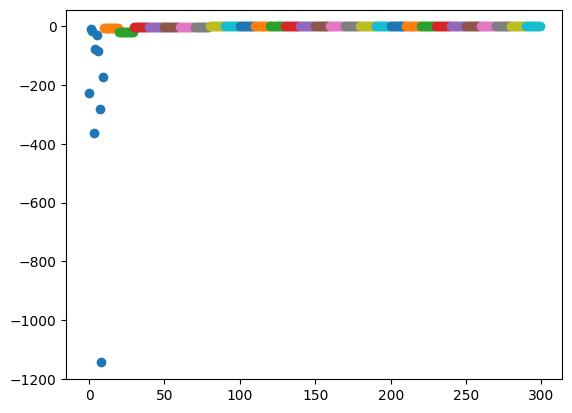

In [44]:
Iteration_Y = np.split(Y_data,iterations)

np.shape(Iteration_Y[0])

for i in range(iterations):
    plt.scatter(range(i*len(Iteration_Y[i]),(i+1)*len(Iteration_Y[i])),Iteration_Y[i])
